# Toxicity Prediction of first column "NR-AhR" of 12 columns

In [1]:
#!pip install ase

In [2]:
#!pip install tensorflow

In [3]:
import os
from tensorflow.python.client import device_lib
import tensorflow as tf

2024-11-07 16:04:56.089396: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 16:04:56.120586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 16:04:56.627374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_lib.list_local_devices()

2024-11-07 16:04:59.858309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 45793 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:ac:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12506412517482993247
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48018358272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3356007442847745332
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:ac:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [5]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model

In [6]:
#!git clone https://github.com/dmamur/elementsem.git

In [7]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembert_'
    MVER = 'V1'
    DSPATH="./data/"
    PREPATH="./models/pretrained/"
    PATH="./models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [8]:
#'sider_1','sider_2','sider_3','sider_4','sider_5', 'sider_6','sider_7', 'sider_8', 'sider_9', 'sider_10', 'sider_11', 'sider_12',
#'sider_13', 'sider_14', 'sider_15','sider_16','sider_17','sider_18','sider_19','sider_20','sider_21','sider_22','sider_23',
#'sider_24','sider_25','sider_26','sider_27','dimensionality','spacegroup','liquid_amorphous','BBBP','bace','clintox','nr-ahr',
#'nr-ar','sr-atad5','nr-er-lbd','sr-p53','nr-ar-lbd','nr-ppar-gamma','sr-hse','nr-er','sr-mmp','nr-aromatase','sr-are','HIV'
ds = 'toxic_nr-ahr'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

In [9]:
if (ds=='HIV'):
  df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')
else:
  df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)

vocabSize:  565


In [10]:
# custom data

custom_df = pd.read_csv("./data/custom_data.csv")

custom_types = custom_df["types"+config.MVER].apply(eval).apply(list)

2024-11-07 16:05:35.546431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45793 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:ac:00.0, compute capability: 8.6


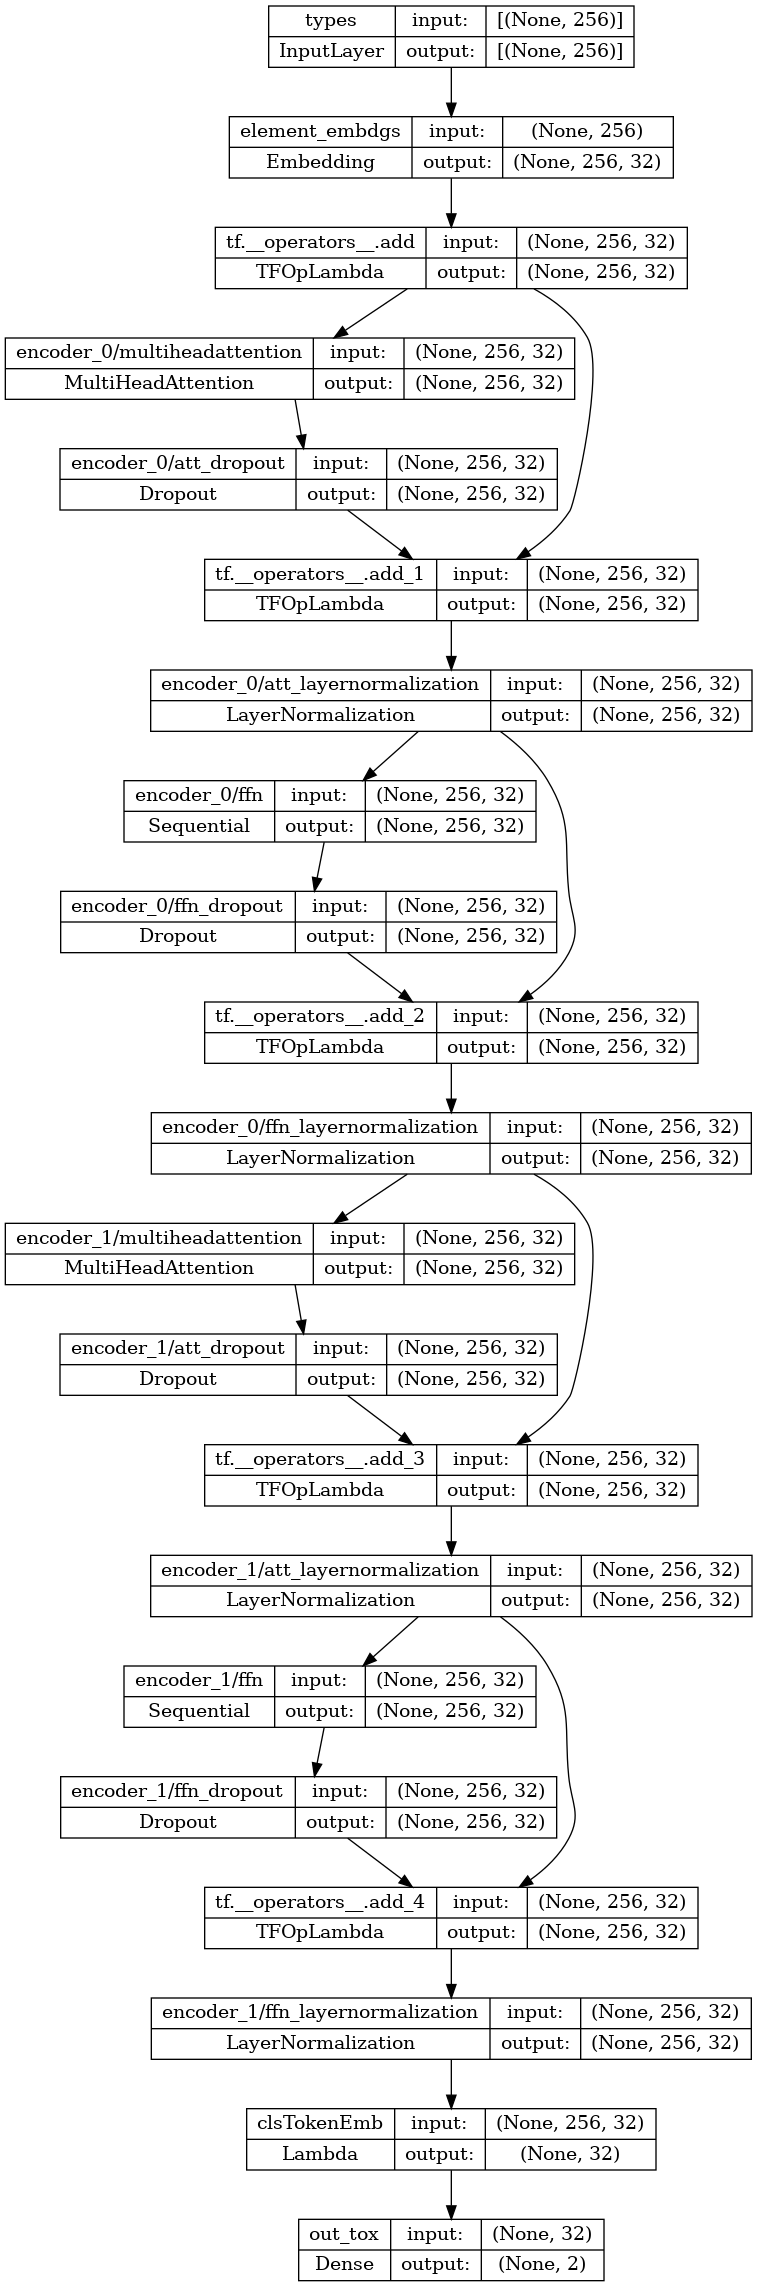

In [11]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/elembert_%s_E_%s_H_%s_L_%s.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

In [12]:
# custom data

custom_types0=[['[CLS]']+i+['[SEP]'] for i in custom_types]
custom_typesNumerical=[]
for i in custom_types0:
    custom_typesNumerical.append([element2id[j] for j in i])

custom_x3 = tf.keras.preprocessing.sequence.pad_sequences(custom_typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

In [13]:
#pip install pydot

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 types (InputLayer)          [(None, 256)]                0         []                            
                                                                                                  
 element_embdgs (Embedding)  (None, 256, 32)              18080     ['types[0][0]']               
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 32)              0         ['element_embdgs[0][0]']      
 Lambda)                                                                                          
                                                                                                  
 encoder_0/multiheadattenti  (None, 256, 32)              4224      ['tf.__operators__.add[0][

 OpLambda)                                                          tion[0][0]',                  
                                                                     'encoder_1/ffn_dropout[0][0]'
                                                                    ]                             
                                                                                                  
 encoder_1/ffn_layernormali  (None, 256, 32)              64        ['tf.__operators__.add_4[0][0]
 zation (LayerNormalization                                         ']                            
 )                                                                                                
                                                                                                  
 clsTokenEmb (Lambda)        (None, 32)                   0         ['encoder_1/ffn_layernormaliza
                                                                    tion[0][0]']                  
          

In [15]:
epochs=4*config.BATCH_SIZE

print('dataLen: ',x3.shape,labels.shape)

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:int(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE)

model.save(mname+".h5")

dataLen:  (8169, 256) (8169, 2)
Epoch 1/128


2024-11-07 16:05:46.435855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-07 16:05:46.468999: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x711f89580840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 16:05:46.469033: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-07 16:05:46.474366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 16:05:46.488857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-11-07 16:05:46.525707: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-07 16:05:46.576698: I ./

205/205 [==============================] - 7s 15ms/step - loss: 0.3886 - auc: 0.8812 - val_loss: 0.3573 - val_auc: 0.8858
Epoch 2/128
205/205 [==============================] - 1s 6ms/step - loss: 0.3633 - auc: 0.8850 - val_loss: 0.3562 - val_auc: 0.9037
Epoch 3/128
205/205 [==============================] - 1s 7ms/step - loss: 0.3614 - auc: 0.8867 - val_loss: 0.3533 - val_auc: 0.9408
Epoch 4/128
205/205 [==============================] - 1s 6ms/step - loss: 0.3276 - auc: 0.9268 - val_loss: 0.2752 - val_auc: 0.9542
Epoch 5/128
205/205 [==============================] - 1s 5ms/step - loss: 0.2887 - auc: 0.9486 - val_loss: 0.2852 - val_auc: 0.9540
Epoch 6/128
205/205 [==============================] - 1s 5ms/step - loss: 0.2807 - auc: 0.9516 - val_loss: 0.2732 - val_auc: 0.9549
Epoch 7/128
205/205 [==============================] - 1s 6ms/step - loss: 0.2763 - auc: 0.9533 - val_loss: 0.2653 - val_auc: 0.9574
Epoch 8/128
205/205 [==============================] - 1s 5ms/step - loss: 0.274

/home/dbsejrgus226/miniconda3/envs/elembert/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(custom_x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(custom_x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx
dbresults['validx'] = validx

with open("custom_data_nr-ahr"+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

2/2 [==============================] - 0s 6ms/step
